# Explore Runtimes:

In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/analysis/BXD"

In [2]:
cd("..")

In [3]:
include("../test/BXDdata_for_test.jl");

In [4]:
include("../src/parallel_helpers.jl");

In [5]:
size(pheno)

(79, 35556)

In [6]:
size(pheno_y)

(79, 1)

In [7]:
size(geno)

(79, 7321)

In [8]:
size(kinship)

(79, 79)

In [9]:
(n, m, p)

(79, 35556, 7321)

In [10]:
Threads.nthreads()

16

In [11]:
using LinearAlgebra

In [12]:
BLAS.get_num_threads()

8

In [13]:
BLAS.set_num_threads(1);

In [14]:
BLAS.get_num_threads()

1

In [ ]:
function scan_ordinary(Y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1}; reml::Bool = true)
    
    X0_inter = reshape(X0[:, 1], :, 1);
    
    full_results_ordinary = Array{Float64, 2}(undef, p, m);
    
    for i in 1:m
        y0i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0i, X0_inter, lambda0; reml = true);
        sqrtw = sqrt.(makeweights(out00.h2, lambda0))
        
        yw_i = rowMultiply(y0i, sqrtw);
        Xw = rowMultiply(X0, sqrtw);
        
        out0 = rss(yw_i, reshape(Xw[:, 1], :, 1));
        lod = Array{Float64, 1}(undef, p);
        
        X = Array{Float64, 2}(undef, n, 2);
        X[:, 1] = Xw[:, 1];
        
        for j in 1:p
            X[:, 2] = Xw[:, j+1];
            
            out1 = rss(yw_i, X);
            lod[j] = (n/2)*(log10(out0[1]) - log10(out1[1]))
        end
        
        full_results_ordinary[:, i] = lod;

    end
    
    
    return full_results_ordinary
end

In [ ]:
@time begin
    
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship);
    full_results_ordinary = scan_ordinary(Y0, X0, lambda0);
    
end

## LiteQTL:

In [80]:
(m, n, p)

(35556, 79, 7321)

In [82]:
function r2lod(r::Float64, n::Int64)
    rsq = (r/n)^2
    return -(n/2.0) * log10(1.0-rsq);
end

r2lod (generic function with 3 methods)

In [85]:
map(x -> r2lod(x, n), [0.9, 0.1])

2-element Vector{Float64}:
 0.0022265908888506967
 2.748701454592006e-5

In [108]:
full_results_lite = Array{Float64, 2}(undef, p, m);

In [109]:
@time begin
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship);
    X0_intercept = reshape(X0[:, 1], :, 1);
    #copyX0_intercept = deepcopy(X0_intercept);
    X0_covar = X0[:, 2:end];
    #copyX0_covar = deepcopy(X0_covar);
    
    for i in 1:m
        pheno_y0i = reshape(Y0[:, i], :, 1);
        vc = fitlmm(pheno_y0i, X0_intercept, lambda0; reml = true);
        sqrtw = sqrt.(makeweights(vc.h2, lambda0));
    
        pheno_y00i = rowMultiply(pheno_y0i, sqrtw);
        X00_intercept = rowMultiply(X0_intercept, sqrtw);
        X00_covar = rowMultiply(X0_covar, sqrtw);
    
        y00 = resid(pheno_y00i, X00_intercept);
        X00 = resid(X00_covar, X00_intercept);
        
        sy = std(y00, dims = 1) |> vec;
        sx = std(X00, dims = 1) |> vec;
        colDivide!(y00, sy);
        colDivide!(X00, sx);
        R = y00' * X00;
    
        full_results_lite[:, i] = r2lod.(R, 79);
    
    end

end

228.439247 seconds (33.90 M allocations: 484.262 GiB, 11.94% gc time, 0.01% compilation time)


In [ ]:
full_results_lite[1:6, :]

### Multi-threading LiteQTL:

In [17]:
Threads.nthreads()

16

In [18]:
nblocks = Threads.nthreads();

In [19]:
if nblocks == Threads.nthreads()
    BLAS.set_num_threads(1)
else
    BLAS.set_num_threads(Threads.nthreads() - nblocks)
end

In [20]:
BLAS.get_num_threads()

1

In [21]:
divrem(m, 16)

(2222, 4)

In [106]:
function scan_lite_univar(y0_j::Array{Float64, 1}, X0_intercept::Array{Float64, 2}, 
                            X0_covar::Array{Float64, 2}, lambda0::Array{Float64, 1};
                            reml::Bool = true)
    
    y0 = reshape(y0_j, :, 1);
    vc = fitlmm(y0, X0_intercept, lambda0; reml = reml);
    sqrtw = sqrt.(makeweights(vc.h2, lambda0));
    
    wy0 = rowMultiply(y0, sqrtw);
    wX0_intercept = rowMultiply(X0_intercept, sqrtw);
    wX0_covar = rowMultiply(X0_covar, sqrtw);
    
    y00 = resid(wy0, wX0_intercept);
    X00 = resid(wX0_covar, wX0_intercept);
        
        
    sy = std(y00, dims = 1) |> vec;
    sx = std(X00, dims = 1) |> vec;
    colDivide!(y00, sy);
    colDivide!(X00, sx);
    
    R = X00' * y00; # p-by-1 matrix
    
    return r2lod.(R, 79); # results will be p-by-1, i.e. all LOD scores for the j-th trait and p markers
end

scan_lite_univar (generic function with 1 method)

In [23]:
function scan_lite_multithreads(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, nb::Int64;
                                reml::Bool = true)
    (n, m) = size(Y);
    p = size(G, 2);
    
    # rotate data
    (Y0, X0, lambda0) = transform_rotation(Y, G, K);
    X0_intercept = reshape(X0[:, 1], :, 1);
    X0_covar = X0[:, 2:end];
    
    (len, rem) = divrem(m, nb);
    
    results = Array{Array{Float64, 2}, 1}(undef, nb);
    
    Threads.@threads for t = 1:nb # so the N blocks will share the (nthreads - N) BLAS threads
        
        lods_currBlock = Array{Float64, 2}(undef, p, len);
        
        @simd for i = 1:len
            
            j = i+(t-1)*len;
            #@inbounds
            lods_currBlock[:, i] = scan_lite_univar(Y0[:, j], X0_intercept, X0_covar, lambda0;
                                                    reml = reml);
        end
                    
        results[t] = lods_currBlock;
        
    end
    
    # process up the remaining data
    lods_remBlock = Array{Float64, 2}(undef, p, rem);
    for i in 1:rem
        
        j = m-rem+i;
        
        lods_remBlock[:, i] = scan_lite_univar(Y0[:, j], X0_intercept, X0_covar, lambda0;
                                               reml = reml);
        
    end
    
    LODs_all = reduce(hcat, results);
    LODs_all = hcat(LODs_all, lods_remBlock);
    
    return LODs_all
    
end

scan_lite_multithreads (generic function with 1 method)

In [24]:
@time full_results_lite_multithreads = scan_lite_multithreads(pheno, geno, kinship, nblocks; reml = true);

 62.603721 seconds (2.12 G allocations: 521.142 GiB, 28.09% gc time, 0.32% compilation time)


In [ ]:
@btime scan_lite_multithreads(pheno, geno, kinship, nblocks; reml = true);

In [ ]:
full_results_lite[1:6, :]

In [25]:
full_results_lite_multithreads[1:6, :]

6×35556 Matrix{Float64}:
 0.000117904  0.0449468  0.00289554  …  0.0457906  0.00329113  0.344878
 0.000117904  0.0449468  0.00289554     0.0457906  0.00329113  0.344878
 0.000117904  0.0449468  0.00289554     0.0457906  0.00329113  0.344878
 0.000117904  0.0449468  0.00289554     0.0457906  0.00329113  0.344878
 0.000117904  0.0449468  0.00289554     0.0457906  0.00329113  0.344878
 0.000117904  0.0449468  0.00289554  …  0.0457906  0.00329113  0.344878

In [ ]:
maxSqDiff(full_results_lite, full_results_lite_multithreads)

In [26]:
any(full_results_lite_multithreads .< 0.0)

false

In [ ]:
test[2] = [1 2; 3 4; 5 6]

In [ ]:
test

In [ ]:
reduce(hcat, test[1:2])

### "Bulk" Calculation:

In [89]:
function scan_lite_multivar(Y0::Array{Float64, 2}, X0::Array{Float64, 2}, 
                            hsq::Float64, lambda0::Array{Float64, 1};
                            reml::Bool = true)
    
    sqrtw = sqrt.(makeweights(hsq, lambda0));
    
    wY0 = rowMultiply(Y0, sqrtw);
    wX0 = rowMultiply(X0, sqrtw);
    
    wX0_intercept = wX0[:, 1];
    wX0_covar = wX0[:, 2:end];
    
    Y00 = resid(wY0, wX0_intercept);
    X00 = resid(wX0_covar, wX0_intercept);
        
        
    sy = std(Y00, dims = 1) |> vec;
    sx = std(X00, dims = 1) |> vec;
    colDivide!(Y00, sy);
    colDivide!(X00, sx);
    
    R = X00' * Y00; # p-by-m matrix
    
    return r2lod.(R, 79); # results will be p-by-1, i.e. all LOD scores for the j-th trait and p markers
end

scan_lite_multivar (generic function with 1 method)

In [73]:
test_w = sqrt.(makeweights(0.1, lambda0));

In [74]:
@time begin
    test_wY0 = rowMultiply(Y0, test_w);
    test_wX0 = rowMultiply(X0, test_w);
end;

  0.006996 seconds (4 allocations: 25.844 MiB)


In [75]:
@time begin
    test_wX0_intercept = test_wX0[:, 1];
    test_wX0_covar = test_wX0[:, 2:end];
end;

  0.001187 seconds (8 allocations: 4.413 MiB)


In [76]:
@time begin
    test_Y00 = resid(test_wY0, test_wX0_intercept);
    test_X00 = resid(test_wX0_covar, test_wX0_intercept);
end;

  0.044112 seconds (18 allocations: 52.341 MiB, 20.46% gc time)


In [77]:
@time begin
    sy = std(test_Y00, dims = 1) |> vec;
    sx = std(test_X00, dims = 1) |> vec;
    colDivide!(test_Y00, sy);
    colDivide!(test_X00, sx);
end;

  0.033638 seconds (24 allocations: 671.531 KiB)


In [78]:
@time test_R = test_X00' * test_Y00;

  0.656654 seconds (3 allocations: 1.939 GiB, 7.31% gc time)


In [87]:
@time test_L = map(x -> r2lod(x, 79), test_R);

  3.633648 seconds (115.25 k allocations: 1.946 GiB, 0.56% gc time, 1.44% compilation time)


In [88]:
(Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship);

In [43]:
BLAS.set_num_threads(8)

In [44]:
BLAS.get_num_threads()

8

In [91]:
@time scan_lite_multivar(Y0, X0, 0.1, lambda0);

  4.104814 seconds (57 allocations: 3.960 GiB, 3.39% gc time)


In [92]:
function bulk_scan(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, hsq_list::Array{Float64, 1};
                reml::Bool = true)
    
    (Y0, X0, lambda0) = transform_rotation(Y, G, K);
    
    maxL = scan_lite_multivar(Y0, X0, hsq_list[1], lambda0);
    
    for hsq in hsq_list[2:end]
        
        currL = scan_lite_multivar(Y0, X0, hsq, lambda0);
        maxL = max.(maxL, currL);
        
    end
    
    return maxL
      
end

bulk_scan (generic function with 1 method)

In [93]:
hsq_grids = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0];

In [94]:
@time full_results_bulkscan = bulk_scan(pheno, geno, kinship, hsq_grids; reml = true);

 54.001050 seconds (672 allocations: 62.986 GiB, 5.09% gc time)


In [95]:
full_results_bulkscan[1:6, 1:6]

6×6 Matrix{Float64}:
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938
 0.0949517  0.124677  0.0935413  0.0359656  0.101819  0.0918938

In [96]:
full_results_lite_multithreads[1:6, 1:6]

6×6 Matrix{Float64}:
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821
 0.000117904  0.0449468  0.00289554  0.0157737  0.0979217  0.0903821

In [99]:
maximum(full_results_lite_multithreads .- full_results_bulkscan)

5.502433620572326

In [100]:
minimum(full_results_lite_multithreads .- full_results_bulkscan)

-21.781019883518805

In [101]:
using Plots

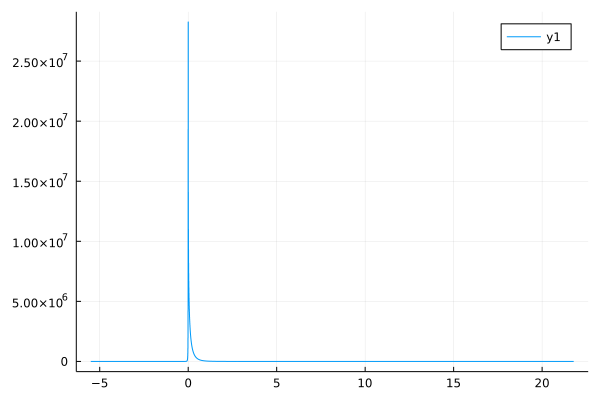

In [103]:
histogram(vec(full_results_bulkscan) .- vec(full_results_lite_multithreads))

In [54]:
m*p

260305476

## Estimate heritability independently for every trait:

### Iteratively:

In [104]:
function get_weights_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    return sqrtw
    
end

function get_h2s_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    # sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    # return sqrtw
    return out00.h2
    
end

get_h2s_for_timing (generic function with 1 method)

In [ ]:
m

In [ ]:
nprocs()

In [ ]:
Threads.nthreads()

In [105]:
(Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits

In [ ]:
h2s_list = Array{Float64, 1}(undef, m);
weights_list = Array{Float64, 2}(undef, n, m);

In [ ]:
@time begin 
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    for k in 1:m
        y0_k = reshape(Y0[:, k], :, 1);
        h2s_list[k] = get_h2s_for_timing(y0_k, X0, lambda0; reml = true);
    end
    
end

In [ ]:
@time begin
    
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    for k in 1:m
        y0_k = reshape(Y0[:, k], :, 1);
        weights_list[:, k] = get_weights_for_timing(y0_k, X0, lambda0; reml = true);
    end
    
end

In [ ]:
get_weights_for_timing(reshape(Y0[:, 7919], :, 1), X0, lambda0; reml = true)

In [ ]:
histogram(h2s_list, legend = false)

In [ ]:
p

In [ ]:
lod = Array{Float64, 2}(undef, p, m);

In [ ]:
BLAS.get_num_threads()

In [ ]:
function threads_by_blocks(r0perm::Array{Float64, 2}, X00::Array{Float64, 2}, nblocks::Int64)
    # Does distributed processes of calculations of LOD scores for markers in each block

    p = size(X00, 2);

    ## (Create blocks...)
    
    block_size = ceil(Int, p/nblocks);
    blocks = createBlocks(p, block_size);

    LODs_blocks = tmap(x -> calcLODs_block(r0perm, X00, x), 16, blocks);
    results = reduce(hcat, LODs_blocks);

    return results

end

In [ ]:
function scan_perms_threadsBlocks(y::Array{Float64,2}, g::Array{Float64,2}, K::Array{Float64,2};
                                reml::Bool = false,
                                nperms::Int64 = 1024, rndseed::Int64 = 0, original::Bool = true,
                                # (options for blocks, nperms distribution methods...)
                                option::String = "by blocks", nblocks::Int64 = 1, ncopies::Int64 = 1, 
                                nprocs::Int64 = 0)

    (y0, X0, lambda0) = transform_rotation(y, g, K); # rotation of data
    (r0, X00) = transform_reweight(y0, X0, lambda0; reml = reml); # reweighting and taking residuals
    r0perm = transform_permute(r0; nperms = nperms, rndseed = rndseed, original = original);

    if option == "by blocks"
        results = threads_by_blocks(r0perm, X00, nblocks);
    elseif option == "by nperms"
        results = distribute_by_nperms(r0, X00, nperms, ncopies, original);
    else
        throw(error("Option unsupported."))
    end

    return results

end

In [ ]:
block_bounds = quantile(h2s_list, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [ ]:
length(block_bounds)/2

In [ ]:
sum(map(x -> (x < block_bounds[5] && x > block_bounds[4]), h2s_list))

### Parellely:

#### Distributed-processes

In [ ]:
using Distributed

In [ ]:
@everywhere begin
    
    include("../test/BXDdata_for_test.jl");
    include("../src/parallel_helpers.jl");
    
    function get_h2s_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    # sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    # return sqrtw
    return out00.h2
    
    end
end

In [ ]:
@time begin 
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    pmap_h2s = pmap(x -> get_h2s_for_timing(reshape(Y0[:, x], :, 1), X0, lambda0; reml = true), 1:m)
end

In [ ]:
Threads.nthreads()